# Assignment 2

## Setup & Dataset Retrieval

In [1]:
import os.path
import logging
import pickle
from typing import Dict

import numpy as np
import rank_bm25 as bm25
from beir import util, LoggingHandler
from beir.datasets.data_loader import GenericDataLoader

import src.utilities.tokenization as tkn
import src.utilities.scores as scr
import src.utilities.evaluation as eva

/Users/a/miniforge3/envs/sbruch-assignment-Lwmd/lib/python3.10/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package stopwords to /Users/a/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Followed beir tutorial to download dataset:
# https://github.com/beir-cellar/beir#beers-quick-example

# Show beir library logs in stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

DATASET_NAME = "trec-covid"
DATASET_URL = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{DATASET_NAME}.zip"
DATA_DIR = "../../data"

# Download only if necessary
if not os.path.exists(os.path.join(DATA_DIR, DATASET_NAME)):
    data_path = util.download_and_unzip(DATASET_URL, DATA_DIR)
else:
    data_path = os.path.join(DATA_DIR, DATASET_NAME)

In [3]:
# Load documents, queries and ground truth from the downloaded dataset.
# Ground truth here is referred to as `_` because we do not care about it,
#   part of the assignment is to calculate our own ground truth
data: tkn.Dataset = GenericDataLoader(data_folder=data_path).load(split="test")
documents, queries, _ = data

2023-04-28 02:50:17 - Loading Corpus...


  0%|          | 0/171332 [00:00<?, ?it/s]

2023-04-28 02:50:20 - Loaded 171332 TEST Documents.
2023-04-28 02:50:20 - Doc Example: {'text': 'OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract 

In [4]:
len(documents)

171332

## Tokenization

In [5]:
# document & query cleaning and tokenization
TOKENS_DIR = os.path.join(data_path, "tokens")
if not os.path.exists(TOKENS_DIR):
    os.mkdir(TOKENS_DIR)

QUERY_TOKENS_PATH = os.path.join(TOKENS_DIR, "query_tokens.pkl")
DOCS_TOKENS_PATH = os.path.join(TOKENS_DIR, "doc_tokens.pkl")

In [6]:
if not os.path.exists(DOCS_TOKENS_PATH):
    tokenized_docs: tkn.TokenizedDocuments = tkn.get_tokenized_documents(documents)

    with open(DOCS_TOKENS_PATH, "wb") as f:
        pickle.dump(tokenized_docs, f)
else:
    with open(DOCS_TOKENS_PATH, "rb") as f:
        tokenized_docs: tkn.TokenizedDocuments = pickle.load(f)

tokenized_docs[0:10]

[TokenizedText(text_id='ug7v899j', tokens=['clinical', 'features', 'culture', 'proven', '##co', '##pl', '##as', '##ma', 'pneumonia', '##e', 'infections', 'king', 'abdul', '##azi', '##z', 'university', 'hospital', 'jed', '##dah', 'saudi', 'arabia', 'objective', 'retrospective', 'chart', 'review', 'describes', 'ep', '##ide', '##mi', '##ology', 'clinical', 'features', '40', 'patients', 'culture', 'proven', '##co', '##pl', '##as', '##ma', 'pneumonia', '##e', 'infections', 'king', 'abdul', '##azi', '##z', 'university', 'hospital', 'jed', '##dah', 'saudi', 'arabia', 'methods', 'patients', 'positive', 'pneumonia', '##e', 'cultures', 'respiratory', 'specimens', 'january', '1997', 'december', '1998', 'identified', 'micro', '##biology', 'records', 'charts', 'patients', 'reviewed', 'results', '40', 'patients', 'identified', '33', '82', '5', 'required', 'admission', 'infections', '92', '5', 'community', 'acquired', 'infection', 'affected', 'age', 'groups', 'common', 'infants', '32', '5', 'pre', 's

In [7]:
if not os.path.exists(QUERY_TOKENS_PATH):
    tokenized_queries: tkn.TokenizedQueries = tkn.get_tokenized_queries(queries)

    with open(QUERY_TOKENS_PATH, "wb") as f:
        pickle.dump(tokenized_queries, f)
else:
    with open(QUERY_TOKENS_PATH, "rb") as f:
        tokenized_queries: tkn.TokenizedQueries = pickle.load(f)

tokenized_queries[0:10]

[TokenizedText(text_id='1', tokens=['origin', 'co', '##vid', '19']),
 TokenizedText(text_id='2', tokens=['corona', '##virus', 'respond', 'changes', 'weather']),
 TokenizedText(text_id='3', tokens=['sar', '##s', 'co', '##v', '##2', 'infected', 'people', 'develop', 'immunity', 'cross', 'protection', 'possible']),
 TokenizedText(text_id='4', tokens=['causes', 'death', 'co', '##vid', '19']),
 TokenizedText(text_id='5', tokens=['drugs', 'active', 'sar', '##s', 'co', '##v', 'sar', '##s', 'co', '##v', '2', 'animal', 'studies']),
 TokenizedText(text_id='6', tokens=['types', 'rapid', 'testing', 'co', '##vid', '19', 'developed']),
 TokenizedText(text_id='7', tokens=['ser', '##ological', 'tests', 'detect', 'antibodies', 'corona', '##virus']),
 TokenizedText(text_id='8', tokens=['lack', 'testing', 'availability', 'led', '##re', '##port', '##ing', 'true', 'incidence', 'co', '##vid', '19']),
 TokenizedText(text_id='9', tokens=['co', '##vid', '19', 'affected', 'canada']),
 TokenizedText(text_id='10',

These two maps are used to map the raw numpy array indices to their actual text ids in the original dataset.
This is useful to later retrieve the original text

These index-to-ID mappings can be useful for looking up documents or queries by their index in a list or array, rather than by their text ID. For example, if you have a list of relevance scores for each query-document pair, you could use these mappings to look up the text IDs of the corresponding queries and documents based on their index in the relevance score list.

In [8]:
doc_idx_to_id = {
    i: d.text_id for i, d in enumerate(tokenized_docs)
}

query_idx_to_id = {
    i: q.text_id for i, q in enumerate(tokenized_queries)
}

note:
Yes, the BERT-base-uncased pre-trained model automatically converts input text to lower case. This means that all text input is converted to lower case before being processed by the model. This is because the model was trained on a large corpus of text that was pre-processed in this way, and so it has learned to recognize patterns and features based on lower case text.
stop words and punctuation marks are kept (see why)

## Embeddings & Document Scores

In [9]:
BM25_SCORER = bm25.BM25Okapi(corpus=[d.tokens for d in tokenized_docs])

scores_by_query_id: Dict[str, eva.ScoresPair] = {}  # query_id: (dense, sparse)

SCORES_SPARSE_DIR_PATH = os.path.join(data_path, "scores_sparse")
SCORES_DENSE_DIR_PATH = os.path.join(data_path, "scores_dense")

In [10]:
for q_idx, q_text in enumerate(queries.values()):
    print("{} {}".format(q_idx, q_text))

0 what is the origin of COVID-19
1 how does the coronavirus respond to changes in the weather
2 will SARS-CoV2 infected people develop immunity? Is cross protection possible?
3 what causes death from Covid-19?
4 what drugs have been active against SARS-CoV or SARS-CoV-2 in animal studies?
5 what types of rapid testing for Covid-19 have been developed?
6 are there serological tests that detect antibodies to coronavirus?
7 how has lack of testing availability led to underreporting of true incidence of Covid-19?
8 how has COVID-19 affected Canada
9 has social distancing had an impact on slowing the spread of COVID-19?
10 what are the guidelines for triaging patients infected with coronavirus?
11 what are best practices in hospitals and at home in maintaining quarantine?
12 what are the transmission routes of coronavirus?
13 what evidence is there related to COVID-19 super spreaders
14 how long can the coronavirus live outside the body
15 how long does coronavirus remain stable  on surface

Sparse

In [11]:
if not os.path.exists(SCORES_SPARSE_DIR_PATH):
    os.mkdir(SCORES_SPARSE_DIR_PATH)

    # Compute the sparse scores and store them in a dictionary
    sparse_scores_dict = {}
    for q_idx, q_text in enumerate(queries.values()):
        sparse = scr.get_sparse_embeddings_scores(query=tokenized_queries[q_idx], scorer=BM25_SCORER)
        sparse_scores_dict[q_idx] = sparse

        q_id = query_idx_to_id[q_idx]
        np.savetxt(os.path.join(SCORES_SPARSE_DIR_PATH, f"sparse_scores_{q_id}.np"), sparse, delimiter=",")
else:
    sparse_scores_dict = {}
    for q_id in queries.keys():
        sparse_path = os.path.join(SCORES_SPARSE_DIR_PATH, f"sparse_scores_{q_id}.np")

        if not os.path.exists(sparse_path):
            break

        sparse = np.genfromtxt(sparse_path, delimiter=",")
        sparse_scores_dict[q_id] = sparse

In [12]:
sparse_scores_dict

{'1': array([0.        , 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163]),
 '2': array([0.        , 0.        , 3.48564137, ..., 0.        , 0.        ,
        0.        ]),
 '3': array([2.85016095, 2.16167487, 4.09033264, ..., 6.75969762, 4.27307094,
        0.32112529]),
 '4': array([0.        , 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163]),
 '5': array([ 6.6980002 ,  4.32334973,  8.18066528, ..., 13.51939525,
         0.65654941,  0.64225057]),
 '6': array([0.        , 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163]),
 '7': array([0., 0., 0., ..., 0., 0., 0.]),
 '8': array([0.        , 0.        , 0.        , ..., 0.        , 4.45552145,
        2.39264163]),
 '9': array([2.52696734, 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163]),
 '10': array([0.        , 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163]),
 '11': array([2.05973386, 0.        , 0.        ,

Dense

In [13]:
if not os.path.exists(SCORES_DENSE_DIR_PATH):
    os.mkdir(SCORES_DENSE_DIR_PATH)

    # Compute the dense scores and store them in a dictionary
    dense_scores_dict = {}
    embed_docs = scr.get_dense_doc_embeddings(documents)

    for q_idx, q_text in enumerate(queries.values()):
        dense = scr.get_dense_embeddings_scores(query=q_text, doc_embeddings=embed_docs)
        dense_scores_dict[q_idx] = dense

        q_id = query_idx_to_id[q_idx]
        np.savetxt(os.path.join(SCORES_DENSE_DIR_PATH, f"dense_scores_{q_id}.np"), dense, delimiter=",")
else:
    dense_scores_dict = {}
    for q_id in queries.keys():
        dense_path = os.path.join(SCORES_DENSE_DIR_PATH, f"dense_scores_{q_id}.np")

        if not os.path.exists(dense_path):
            break

        dense = np.genfromtxt(dense_path, delimiter=",")
        dense_scores_dict[q_id] = dense

In [14]:
dense_scores_dict

{'1': array([0.16711845, 0.05438465, 0.13295905, ..., 0.01774429, 0.31571466,
        0.50612271]),
 '2': array([0.07786894, 0.05713295, 0.0921341 , ..., 0.04971997, 0.22728199,
        0.40557134]),
 '3': array([0.24615493, 0.07388354, 0.1697164 , ..., 0.11809124, 0.29682451,
        0.34572786]),
 '4': array([ 0.14649266,  0.1461565 ,  0.13629891, ..., -0.04555708,
         0.3275494 ,  0.63145196]),
 '5': array([0.15500069, 0.14475749, 0.26859587, ..., 0.13561472, 0.28927881,
        0.26660568]),
 '6': array([ 0.19211805, -0.01355344,  0.06483191, ..., -0.03478473,
         0.42521459,  0.45228869]),
 '7': array([0.25829685, 0.06593417, 0.11245061, ..., 0.12122586, 0.3982904 ,
        0.37840134]),
 '8': array([ 0.22498471,  0.05566154,  0.04485976, ..., -0.07198979,
         0.456016  ,  0.49012563]),
 '9': array([ 0.09477428,  0.017515  ,  0.09725848, ..., -0.1264824 ,
         0.28660256,  0.4389503 ]),
 '10': array([ 0.10324392,  0.01568676,  0.01736285, ..., -0.07545758,
     

into 1 disctionary

In [15]:
# Merge the two dictionaries into a final dictionary of ScoresPairs
for q_idx in sparse_scores_dict.keys():
    sparse_scores = sparse_scores_dict[q_idx]
    dense_scores = dense_scores_dict[q_idx]
    scores_by_query_id[query_idx_to_id[int(q_idx)-1]] = eva.ScoresPair(dense_scores, sparse_scores)

In [16]:
scores_by_query_id

{'1': ScoresPair(dense=array([0.16711845, 0.05438465, 0.13295905, ..., 0.01774429, 0.31571466,
        0.50612271]), sparse=array([0.        , 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163])),
 '2': ScoresPair(dense=array([0.07786894, 0.05713295, 0.0921341 , ..., 0.04971997, 0.22728199,
        0.40557134]), sparse=array([0.        , 0.        , 3.48564137, ..., 0.        , 0.        ,
        0.        ])),
 '3': ScoresPair(dense=array([0.24615493, 0.07388354, 0.1697164 , ..., 0.11809124, 0.29682451,
        0.34572786]), sparse=array([2.85016095, 2.16167487, 4.09033264, ..., 6.75969762, 4.27307094,
        0.32112529])),
 '4': ScoresPair(dense=array([ 0.14649266,  0.1461565 ,  0.13629891, ..., -0.04555708,
         0.3275494 ,  0.63145196]), sparse=array([0.        , 0.        , 0.        , ..., 0.        , 2.44591055,
        2.39264163])),
 '5': ScoresPair(dense=array([0.15500069, 0.14475749, 0.26859587, ..., 0.13561472, 0.28927881,
        0.26660568]), s

## Evaluation

In [17]:
K_VALUES = [5, 10, 25, 50, 250, 500, 1000, 2500, 5000, 10000]
STEP_SIZES = [1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000, 10000]

RESULTS_DIR = os.path.join(data_path, "results")
RESULTS_FILE_PATH = os.path.join(RESULTS_DIR, "results.pkl")

In [18]:
if not os.path.exists(RESULTS_FILE_PATH):
    os.mkdir(RESULTS_DIR)

    results_by_k: eva.ResultsByK = eva.get_dataset_results(
        scores_by_query_id=scores_by_query_id,
        k_values=K_VALUES,
        idx_to_doc_id=doc_idx_to_id,
        step_sizes=STEP_SIZES
    )

    with open(RESULTS_FILE_PATH, "wb") as f:
        pickle.dump(results_by_k, f)
else:
    with open(RESULTS_FILE_PATH, "rb") as f:
        results_by_k: eva.ResultsByK = pickle.load(f)

In [19]:
list(results_by_k.keys())

[5, 10, 25, 50, 250, 500, 1000, 2500, 5000, 10000]

In [20]:
# choose a value of k to print the recall values for
chosen_k = 5000

# loop through results_by_k dictionary
for k, results in results_by_k.items():
    if k == chosen_k:
        print(f"k = {k}")
        # get a list of all k_prime values for this k
        k_prime_values = sorted(set().union(*(result.recall_by_k_prime.keys() for result in results)))
        print(f"All k_prime values for k = {k}: {k_prime_values}")

k = 5000
All k_prime values for k = 5000: [5000, 5001, 5006, 5016, 5041, 5091, 5166, 5266, 5516, 6016, 7016, 12016, 22016, 32016, 42016, 52016, 62016, 72016, 82016, 92016, 102016, 112016, 122016, 132016, 142016, 152016, 162016]


In [25]:
# choose a value of k_prime to print the recall values for
chosen_k_prime = 5266

# loop through results_by_k dictionary
for k, results in results_by_k.items():
    if k == chosen_k:
        print(f"k = {k}")
        # loop through results for each query
        for result in results:
            query_id = result.query_id
            recall_by_k_prime = result.recall_by_k_prime
            if chosen_k_prime in recall_by_k_prime:
                recall = recall_by_k_prime[chosen_k_prime]
                print(f"Query {query_id}: recall@{chosen_k_prime} = {recall:.4f}")

k = 5000
Query 1: recall@5266 = 0.9840
Query 2: recall@5266 = 0.9766
Query 3: recall@5266 = 0.9728
Query 4: recall@5266 = 0.9942
Query 5: recall@5266 = 0.9922
Query 6: recall@5266 = 0.8712
Query 7: recall@5266 = 0.9570
Query 8: recall@5266 = 0.8414
Query 9: recall@5266 = 0.9998
Query 10: recall@5266 = 0.9750
Query 11: recall@5266 = 0.9302
Query 12: recall@5266 = 0.9410
Query 13: recall@5266 = 0.9960
Query 14: recall@5266 = 0.8456
Query 15: recall@5266 = 0.9744
Query 16: recall@5266 = 0.9664
Query 17: recall@5266 = 0.9604
Query 18: recall@5266 = 0.8928
Query 19: recall@5266 = 0.9758
Query 20: recall@5266 = 0.9560
Query 21: recall@5266 = 0.8820
Query 22: recall@5266 = 0.9350
Query 23: recall@5266 = 0.8824
Query 24: recall@5266 = 0.8658
Query 25: recall@5266 = 0.9100
Query 26: recall@5266 = 0.9208
Query 27: recall@5266 = 0.9058
Query 28: recall@5266 = 0.9306
Query 29: recall@5266 = 0.9794
Query 30: recall@5266 = 0.8990
Query 31: recall@5266 = 0.9572
Query 32: recall@5266 = 0.9990
Query 33

PLOTS

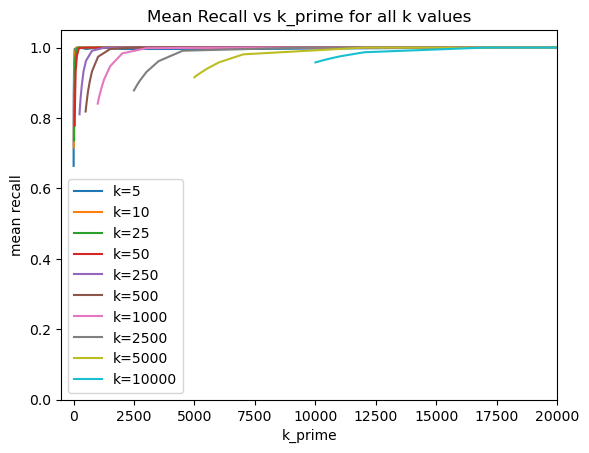

In [22]:
# assuming results_by_k is a dictionary with the results for each k value
eva.plot_mean_recall_vs_k_prime(results_by_k, split_plots=False)

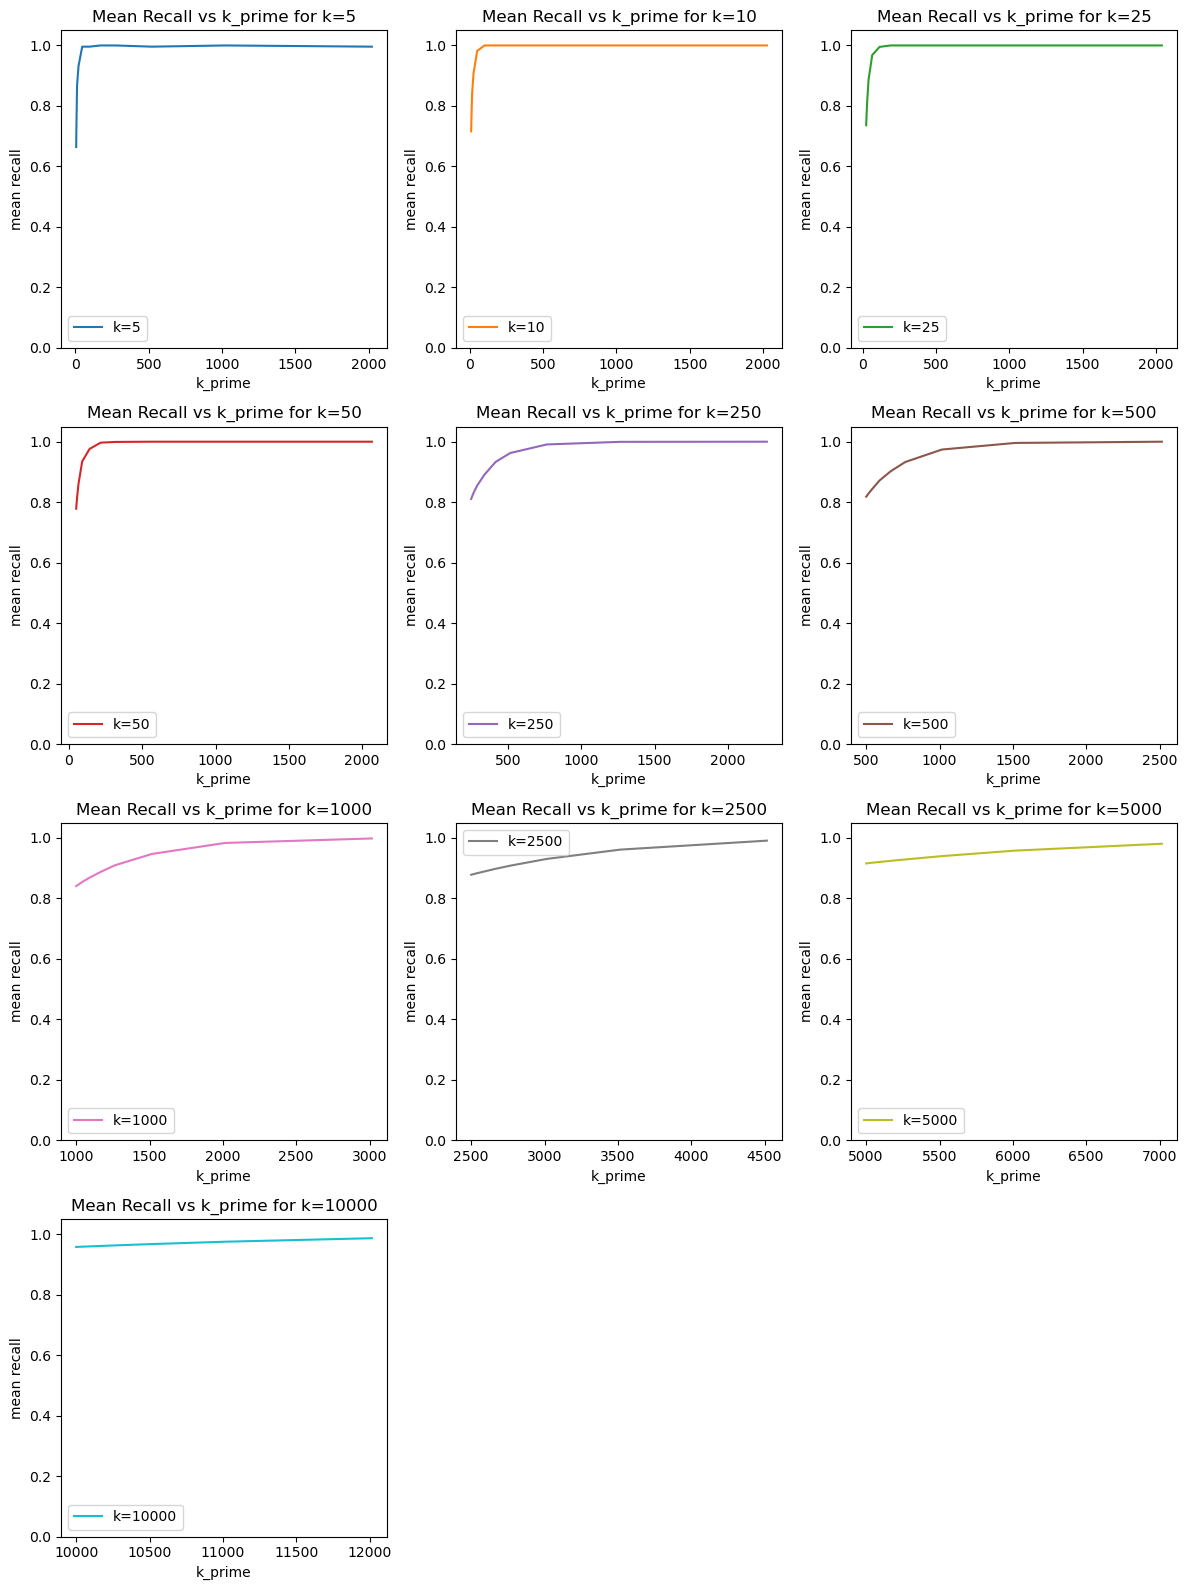

In [23]:
# assuming results_by_k is a dictionary with the results for each k value
eva.plot_mean_recall_vs_k_prime(results_by_k, split_plots=True)